In [1]:
import sys
p = '/home/bram/ANTS/entropy'
import numpy as np
sys.path.append(p)
from core.plugins.helper_functions import bivariate_normal
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(bivariate_normal.__doc__)




    X (meshgrid),Y (meshgrid), sigmax (scalar), sigmay (scalar), mux (scalar),
    muy (scalar) , sigmaxy(scalar)
    FROM https://github.com/matplotlib/matplotlib/blob/81e8154dbba54ac1607b21b22984cabf7a6598fa/lib/matplotlib/mlab.py#L1866
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    


In [2]:
def surf(Z, colormap, X,Y, C=None, shade=None):
    scalarMap = cm.ScalarMappable(norm=Normalize(vmin=Z.min(), vmax=Z.max()), cmap=colormap)

    # outputs an array where each Z value is replaced with a corresponding color value
    C_colored = scalarMap.to_rgba(Z)
    fig = plt.figure()
    ax = Axes3D(fig) #<-- Note the difference from your original code...
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=C_colored, shade=shade)

    return surf

In [3]:
%matplotlib notebook
step= 5
center = (50,50)
stride = int(max(1,np.ceil(1/step)))
X,Y = np.meshgrid(np.arange(0,center[0]*2,step),np.arange(0,center[1]*2,step))
Z = step**2*bivariate_normal(X,Y,sigmax = 10, sigmay=10, mux=50,muy=50)
print(Z[::stride,::stride].shape)
surf_plt = surf(Z[::stride,::stride],colormap = 'PuBu',X=X[::stride,::stride],Y=Y[::stride,::stride])

(20, 20)


<IPython.core.display.Javascript object>

In [4]:
# volume analysis
print(Z.sum())
the_one = np.ones(Z.shape)
the_pike = np.ones(Z.shape)
the_pike[np.dot(center,1/step).astype(np.int64)] = 1e9



0.9999982851815762


In [5]:
def entropy(Z,):
    """ Calculate the shannon entropy of the whole map """
    T=Z.sum()
    M=Z[Z>0.0]
#     M = Z
    return -np.multiply(M/T,np.log(M/T)).sum() # return sum(M/T * log(M/T))

In [6]:
print(entropy(Z))
print(entropy(the_one/the_one.sum()))
print(entropy(the_pike/the_pike.sum()))
print((the_pike/the_pike.sum()).min())

4.224148497782101
5.991464547107983
2.9957326862960345
4.999999905000002e-11


In [7]:
# surf_plt.savefig('tst.png', orientation='landscape', transparent=False,bbox_inches = None,)
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', cmap='PuBu',
               origin='lower', extent=[-3, 3, -3, 3],
               vmax=abs(Z).max(), vmin=-abs(Z).max())

plt.savefig('gauss_test.png',bbox_inches = 'tight')

<IPython.core.display.Javascript object>

In [135]:
cmaps = {'blue': 'PuBu',
         'grey_reverse': 'Greys_r',
         'plasma': 'plasma'
         }

from matplotlib import cm, gridspec
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

class Plotter():
    def __init__(self, M, colormap = 'blue', figsize = (10,6)):
        self.fig = plt.figure(figsize =figsize, constrained_layout = True)
        self.stigmergy_opts = {'cmap':plt.get_cmap(cmaps[colormap]),
                               'extent':[0,M.mesh_x.max().copy(),
                                         0,M.mesh_y.max().copy()],
                               'origin':'bottom'}
        self.gs = gridspec.GridSpec(1,3,width_ratios=[.1,3,.9], figure = self.fig) #2 plots in a single figure
        self.ax_stigmergy = plt.subplot(self.gs[1])
        self.ax_entropy = plt.subplot(self.gs[2])
        self.stigmergy_limits(M.mesh_x.max(), M.mesh_y.max())

    def stigmergy_limits(self,x_max, y_max):
        self.ax_stigmergy.set_xticks(np.arange(0, x_max, 250));
        self.ax_stigmergy.set_yticks(np.arange(0, y_max, 250));
        self.ax_stigmergy.set_xlim((0,x_max))
        self.ax_stigmergy.set_ylim((0,y_max))

    def draw_cb(self):
        self.ax_cb = plt.subplot(self.gs[0])
        fig.colorbar(self.stigmergy,cax = self.ax_cb,orientation = 'vertical',pad=.1)
        
    def draw_stigmergy(self,Z):
        try:
            self.stigmergy.remove()
        except:
            pass
        self.stigmergy = self.ax_stigmergy.imshow(Z,vmin=0,**self.stigmergy_opts)
        
        
    def draw_entropy(self,H, **kwargs):
        " Draw line plot of entropy H "
        try:
             self.entropy.clear()
        except:
            pass
        if not 't' in kwargs:
            t = np.arange(len(H))
        else:
            t=kwargs['t']
        self.entropy = self.ax_entropy.plot(t,H, linestyle=':', color='cornflowerblue', markersize=3, marker = '8')
        self.ax_entropy.set_ylim(0,H.max()*1.05)

    def show(self):
        self.fig.show()
    
    def save(self,path, dpi = 10):
        self.fig.savefig(path,bbox_inches = 'tight', format='eps', dpi=dpi) 
    
    def set_subtitles(self):
        self.ax_stigmergy.set_title('Pheromone volume')
        self.ax_entropy.set_title('entropy')
        
    def set_labels(self, target = ''):
        if target == 'entropy' or target == '':
            self.ax_entropy.set_xlabel('time (s)')
            self.ax_entropy.set_ylabel('Entropy (H)')
        if target == 'stigmergy' or target == '':
            self.ax_stigmergy.set_xlabel('x1 [mm]')
            self.ax_stigmergy.set_ylabel('x2 [mm]')
        


<IPython.core.display.Javascript object>


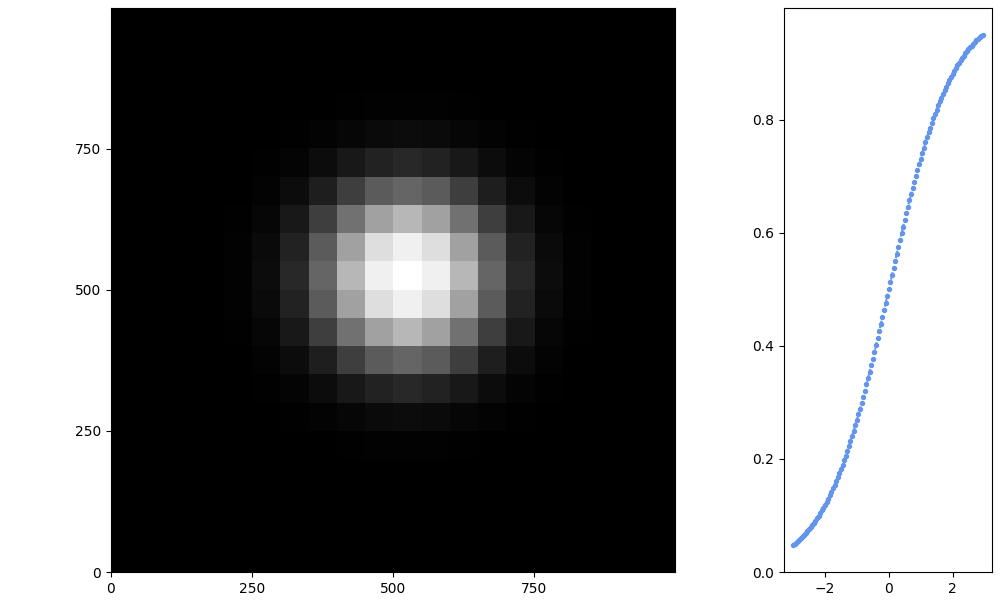

In [137]:
# from core.visualization import Plotter
from core.domain import Domain
D = Domain([1000,1000], 1)
D.Map.map = Z
P = Plotter(D.Map, colormap = 'grey_reverse')
P.draw_stigmergy(Z)
# P.draw_cb()
t = np.arange(-3,3,0.05)
z = 1/(1+np.exp(-t))
P.draw_entropy(z,t=t)
# P.set_subtitles()
# P.set_labels()
P.show()
P.save('gauss_test2.eps')

In [123]:
print(t[t>0])
print(z[t>0].size)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1
 2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8
 2.85 2.9  2.95]
59
